In [11]:
from tqdm.notebook import tqdm as tq
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# %load models.py
import layers
import torch
import torch.nn as nn
import torch.nn.functional as F

# 12 layers!
# k: number of filters to use in intermediate conv layers
# parallels AlphaGo + res layers
class convNet(nn.Module):
    def __init__(self, k, batchNorm = False):
        super(convNet, self).__init__()
        if batchNorm:
            self.model = nn.Sequential(
                layers.symConv2D(55, k, 5),
                nn.BatchNorm2d(k),
                nn.ReLU(),
                layers.resBlock(k),
                layers.resBlock(k),
                layers.resBlock(k),
                layers.resBlock(k),
                layers.resBlock(k), # resBlock # 5 (layer 11)
                layers.OutputLayer(k) # layer 12
            )
        else:
            self.model = nn.Sequential(
                layers.symConv2D(55, k, 5),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3), # layer 5
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.symConv2D(k, k, 3), # layer 10
                nn.ReLU(),
                layers.symConv2D(k, k, 3),
                nn.ReLU(),
                layers.OutputLayer(k) # layer 12
            )

    def forward(self, x):
        return self.model(x)

In [13]:
# %load util.py
import torch
from torch.utils.data import Dataset
import sys
import random
import os
import numpy as np
from datetime import datetime as dt
import glob
from collections import Counter
from sgfmill import sgf
from sgfmill import boards
from sgfmill import ascii_boards
from tqdm import tqdm as tq

class GoDataset(Dataset):
  # pos_paths: list of paths to position features
  # labels: list of moves played in a given position
  def __init__(self, pos_paths, label_paths):
        self.label_paths = label_paths
        self.pos_paths = pos_paths

  def __len__(self):
        return len(self.pos_paths)

  def __getitem__(self, idx):
        pos = torch.load(self.pos_paths[idx])
        pos = pos.permute(2, 0, 1)
        correctClass= torch.load(self.label_paths[idx])
        label = correctClass[0] * 19 + correctClass[1]
        return pos, label

def getPaths(prefix):
    fullDataPaths = []
    fullLabelPaths = []
    for rank in ['5k', '4k', '3k', '2k', '1k', '1d', '2d', '3d', '4d']:
        data = glob.glob(prefix + "data/" + rank + "/*.pt")
        labels = glob.glob(prefix + "labels/" + rank + "/*.pt")
        for i in tq(range(len(data))):
            assert data[i].rsplit('/', 1)[1] == labels[i].rsplit('/', 1)[1]
        fullDataPaths.extend(data)
        fullLabelPaths.extend(labels)
    return fullDataPaths, fullLabelPaths

def getCorrectCount(pred, y):
    # pred: batch_size x 361
    # y: batch_size
    return (torch.argmax(pred, dim = 1) == y).sum()

def buildFeatures(positions):
    # input: 19 x 19 x 3 input: my stones, their stones, empty spots
    # output: 19 x 19 x 32: 
    # 0 - 7 liberties 
    # 8 - 15 self capture size
    # 16 - 23 capture size
    # 24 - 31 liberties after move
    # candidates: open 1 liberty slots for opponent stones
    n = positions.shape[0]

    
    visited = positions[:, :, 2] - 1
    output = torch.zeros((n, n, 32))
    candidates = []
    libertyMap = dict()
    stoneMap = dict()
    colorMap = dict()
    
    def getLiberties(x, y, color, placeholder):
        firstLiberty = None
        liberties = 0
        stoneCount = 1
        visited[x][y] = placeholder
        visited2[x][y] = 1
        if x > 0:
            if visited2[x - 1][y] == 0:
                visited2[x - 1][y] = 1
                if positions[x - 1][y][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x - 1, y]
                    liberties += 1
                elif positions[x - 1][y][color] == 1:
                    l, s, fl = getLiberties(x - 1, y, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        if x < n - 1:
            if visited2[x + 1][y] == 0:
                visited2[x + 1][y] = 1
                if positions[x + 1][y][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x + 1, y]
                    liberties += 1
                elif positions[x + 1][y][color] == 1:
                    l, s, fl = getLiberties(x + 1, y, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        if y > 0:
            if visited2[x][y - 1] == 0:
                visited2[x][y - 1] = 1
                if positions[x][y - 1][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x, y - 1]
                    liberties += 1
                elif positions[x][y - 1][color] == 1:
                    l, s, fl = getLiberties(x, y - 1, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        if y < n - 1:
            if visited2[x][y + 1] == 0:
                visited2[x][y + 1] = 1
                if positions[x][y + 1][2] == 1:
                    if liberties == 0:
                        firstLiberty = [x, y + 1]
                    liberties += 1
                elif positions[x][y + 1][color] == 1:
                    l, s, fl = getLiberties(x, y + 1, color, placeholder)
                    if liberties == 0:
                        firstLiberty = fl
                    liberties += l
                    stoneCount += s
        
        return liberties, stoneCount, firstLiberty
    
    counter = 1
    for i in range(n):
        for j in range(n):
            # visited: -1 if stone is there, 0 if no stone there, counter if visited + stone present
            if visited[i][j] == -1: 
                # visited2: for each loop through connected stones, 1 if visited or liberty has been checked
                visited2 = torch.zeros_like(visited) 
                color = int(positions[i][j][1] == 1) # 0 if your stone, 1 if opponent stone
                l, s, fl = getLiberties(i, j, color, counter)
                libertyMap[counter] = l
                stoneMap[counter] = s
                colorMap[counter] = color # 0 = my color, 1 = their color
                if l == 1 and color == 1:
                    candidates.append((fl[0], fl[1])) # simpleKo candidate: may not be legal move for me to capture
                if l == 1:
                    output[fl[0]][fl[1]][min(s, 8) - 1 + 8 * (color + 1)] = 1 # mark self captures / captures
                counter += 1
    for i in range(n):
        for j in range(n):
            x = int(visited[i][j].item())
            if x == 0: # mark liberties after move
                if i > 0:
                    key = int(visited[i - 1][j].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
                if i < n - 1:
                    key = int(visited[i + 1][j].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
                if j > 0:
                    key = int(visited[i][j - 1].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
                if j < n - 1:
                    key = int(visited[i][j + 1].item())
                    if key != 0 and colorMap[key] == 1:
                        l = libertyMap[key]
                        output[i][j][min(l, 8) + 23] = 1
            else:
                l = libertyMap[x]
                output[i][j][min(l, 8) - 1] = 1 # mark liberty counts for each stone location
            
    return output, candidates 

# 55 features
# 0-2: stone positions
# 3-4: all 0's, all 1's
# 5-12: turn history
# 13 - 36: liberties, self captures, captures
# 37 - 44: liberties after move
# 45: simple ko constraint
# 46 - 54: one hot encoding for rank
def gameToFeatures(game):
    swapColor = {'w': 'b', 'b': 'w'}
    root_node = game.get_root()
    b = boards.Board(19)
    
    rankOneHot = None
    for rankInd, rank in enumerate(['5çº§', '4çº§', '3çº§', '2çº§', '1çº§', '1æ®µ', '2æ®µ', '3æ®µ', '4æ®µ']):        
        if root_node.get("BR") == rank and root_node.get("WR") == rank:
            assert rankOneHot == None
            rankOneHot = rankInd
    assert rankOneHot != None
    
    features = []
    labels = []
    counter = 0
    for node in game.get_main_sequence():
        color, move = node.get_move()
        #print(color, move)
        feature = torch.zeros(19, 19, 55)
        if color == None:
            feature[:, :, 2] = 1
            feature[:, :, 4] = 1
            feature[:, :, 46 + rankOneHot] = 1
        else:
            labels.append([move[0], move[1]])
            b.play(move[0], move[1], color)
            for c, p in b.list_occupied_points():
                if c != color:
                    # my color: c / their color: color (last move made)
                    feature[p[0], p[1], 0] = 1
                else:
                    feature[p[0], p[1], 1] = 1
            feature[:, :, 2] = (feature[:, :, 0] + feature[:, :, 1]) == 0
            feature[:, :, 4] = 1
            feature[move[0], move[1], 5] = 1
            # moves 1-7 history from last feature => 2-8 history of current feature
            feature[:, :, 6:13] = features[-1][:, :, 5:12] 
            feature[:, :, 13:45], candidates = buildFeatures(feature[:, :, :3])
            feature[:, :, 45] = checkSimpleKo(oldb, b, candidates, swapColor[color])
            feature[:, :, 46 + rankOneHot] = 1
        features.append(feature)
        counter += 1
        oldb = b.copy()
    return features[:-1], labels

def checkSimpleKo(past, present, candidates, color):
    n = 19
    output = torch.zeros((n, n))
    for x, y in candidates:
        variation = present.copy()
        try: 
            variation.play(x, y, color)
            if variation.list_occupied_points() == past.list_occupied_points():
                output[x][y] = 1
        except Exception:
            pass
    return output

def filterGame(game, rank):
    board_size = game.get_size()
    if board_size != 19:
        return False
    root_node = game.get_root()
    if root_node.get("BR") != rank:
        return False
    if root_node.get("WR") != rank:
        return False
    if root_node.get("RU") != "Japanese":
        return False
    if root_node.get("TM") != 600:
        return False
    if root_node.get("KM") != 0:
        return False
    if dt.strptime(root_node.get("DT"), '%Y-%m-%d').year != 2017:
        return False
    return True 

In [14]:
!ls models

convFull	  convFull2952799  convFull650624	testConvNoRes300288
convFull100096	  convFull300288   convFull6856510	testConvNoRes350336
convFull1051008   convFull3152991  convFull7306942	testConvNoRes400384
convFull10560029  convFull3253087  convFull750720	testConvNoRes450432
convFull13562876  convFull3353183  convFull7957566	testConvNoRes50048
convFull13763068  convFull350336   convFull8407998	testConvNoRes500480
convFull13963260  convFull3903711  convFull850816	testConvNoRes550528
convFull14163452  convFull3953759  convFull8908445	testConvWRes100096
convFull150144	  convFull400384   convFull900864	testConvWRes150144
convFull1551488   convFull450432   convFull950912	testConvWRes200192
convFull1701632   convFull4604383  test10112		testConvWRes250240
convFull1751680   convFull4854623  test128		testConvWRes300288
convFull1801728   convFull50048    test20224		testConvWRes350336
convFull2202112   convFull500480   test40448		testConvWRes400384
convFull2302208   convFull550528   test50048		test

In [15]:
model = convNet(128)

In [27]:
#model = torch.load("models/testConvNoRes550528")
#model = torch.load("models/testConvWRes500480")
#model = torch.load("models/convFull14163452")
model = torch.load("models2/conv1kRun213800804")

In [28]:
ranks = ['5k', '4k', '3k', '2k', '1k', '1d', '2d', '3d', '4d'] 

In [18]:
testData = []
testLabels = []
for rank in ranks:
    data = glob.glob("../cleanedGoData/test/data/" + rank + "/*.pt")
    labels = glob.glob("../cleanedGoData/test/labels/" + rank + "/*.pt")
    testData.append(data)
    testLabels.append(labels)

In [19]:
len(testData[0])

31941

In [ ]:
'''def getCorrectCount(pred, y):
    # pred: batch_size x 361
    # y: batch_size
    return (torch.argmax(pred, dim = 1) == y).sum()

In [29]:
accs = []
device = torch.device('cuda:0')
for i in range(len(ranks)):
    print("building dataset for rank: ", ranks[i])
    test_data = GoDataset(testData[i], testLabels[i])
    test_loader = DataLoader(test_data, batch_size = 128, shuffle = False, num_workers = 4)
    count = 0
    with tq(total=len(test_loader.dataset)) as progress_bar:
        for batch, (X, y) in enumerate(test_loader):
            X = X.to(device)
            batch_size = X.shape[0]
            pred = model(X)
            y = y.to(device)
            progress_bar.update(batch_size)
            count += getCorrectCount(pred, y)
    acc = count / len(test_loader.dataset)
    print("accuracy: ", acc)
    accs.append(acc)
torch.save(accs, "accs1k.pt")

  0%|          | 0/31941 [00:00<?, ?it/s]

building dataset for rank:  5k


  0%|          | 0/32023 [00:00<?, ?it/s]

accuracy:  tensor(0.4331, device='cuda:0')
building dataset for rank:  4k


  0%|          | 0/32334 [00:00<?, ?it/s]

accuracy:  tensor(0.4288, device='cuda:0')
building dataset for rank:  3k


  0%|          | 0/34316 [00:00<?, ?it/s]

accuracy:  tensor(0.4420, device='cuda:0')
building dataset for rank:  2k


  0%|          | 0/32793 [00:00<?, ?it/s]

accuracy:  tensor(0.4268, device='cuda:0')
building dataset for rank:  1k


  0%|          | 0/29619 [00:00<?, ?it/s]

accuracy:  tensor(0.5160, device='cuda:0')
building dataset for rank:  1d


  0%|          | 0/30418 [00:00<?, ?it/s]

accuracy:  tensor(0.4167, device='cuda:0')
building dataset for rank:  2d


  0%|          | 0/30973 [00:00<?, ?it/s]

accuracy:  tensor(0.4266, device='cuda:0')
building dataset for rank:  3d


  0%|          | 0/31218 [00:00<?, ?it/s]

accuracy:  tensor(0.4243, device='cuda:0')
building dataset for rank:  4d


100%|██████████| 31218/31218 [01:54<00:00, 273.42it/s]

accuracy:  tensor(0.4192, device='cuda:0')


In [30]:
accsNP = []
for acc in accs:
    accsNP.append(acc.item())

In [38]:
acc1k = accsNP

In [45]:
acc1k[4] = pureAcc.item()

In [46]:
acc1k

[0.4331110715866089,
 0.4288480281829834,
 0.44204241037368774,
 0.42676883935928345,
 0.5088992714881897,
 0.4166582524776459,
 0.4265895187854767,
 0.424272745847702,
 0.41924527287483215]

([<matplotlib.axis.YTick at 0x7fc284092cd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

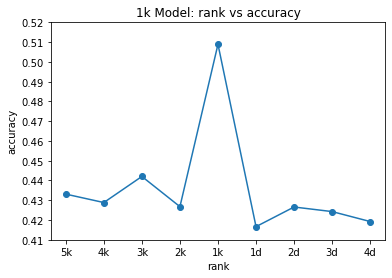

In [50]:
plt.xlabel("rank")
plt.ylabel("accuracy")
#plt.title("All Ranks Model: rank vs accuracy")
plt.title("1k Model: rank vs accuracy")
plt.scatter(ranks, acc1k)
plt.plot(ranks, acc1k)
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,.41,.52))
plt.yticks(np.arange(.41, .52, .01))
#plt.plot(ranks, accs, color = "blue")

In [53]:
torch.load("accsFull.pt")

[tensor(0.5145, device='cuda:0'),
 tensor(0.5133, device='cuda:0'),
 tensor(0.5189, device='cuda:0'),
 tensor(0.5108, device='cuda:0'),
 tensor(0.5160, device='cuda:0'),
 tensor(0.5054, device='cuda:0'),
 tensor(0.5147, device='cuda:0'),
 tensor(0.5104, device='cuda:0'),
 tensor(0.5060, device='cuda:0')]

In [107]:
valDPaths, valLPaths = getPaths("../cleanedGoData/val/") 

  0%|          | 0/32505 [00:00<?, ?it/s]

  0%|          | 0/30276 [00:00<?, ?it/s]

  0%|          | 0/32120 [00:00<?, ?it/s]

  0%|          | 0/31421 [00:00<?, ?it/s]

  0%|          | 0/33065 [00:00<?, ?it/s]

  0%|          | 0/32256 [00:00<?, ?it/s]

  0%|          | 0/31045 [00:00<?, ?it/s]

  0%|          | 0/31018 [00:00<?, ?it/s]

  0%|          | 0/30736 [00:00<?, ?it/s]

In [114]:
valDPaths

['../cleanedGoData/val/data/5k/326884.pt',
 '../cleanedGoData/val/data/5k/337064.pt',
 '../cleanedGoData/val/data/5k/326239.pt',
 '../cleanedGoData/val/data/5k/340828.pt',
 '../cleanedGoData/val/data/5k/334363.pt',
 '../cleanedGoData/val/data/5k/334790.pt',
 '../cleanedGoData/val/data/5k/334825.pt',
 '../cleanedGoData/val/data/5k/322637.pt',
 '../cleanedGoData/val/data/5k/335619.pt',
 '../cleanedGoData/val/data/5k/321790.pt',
 '../cleanedGoData/val/data/5k/337141.pt',
 '../cleanedGoData/val/data/5k/347182.pt',
 '../cleanedGoData/val/data/5k/343997.pt',
 '../cleanedGoData/val/data/5k/335001.pt',
 '../cleanedGoData/val/data/5k/329876.pt',
 '../cleanedGoData/val/data/5k/331297.pt',
 '../cleanedGoData/val/data/5k/339690.pt',
 '../cleanedGoData/val/data/5k/322744.pt',
 '../cleanedGoData/val/data/5k/326499.pt',
 '../cleanedGoData/val/data/5k/325960.pt',
 '../cleanedGoData/val/data/5k/333972.pt',
 '../cleanedGoData/val/data/5k/346842.pt',
 '../cleanedGoData/val/data/5k/340108.pt',
 '../cleane

In [101]:
valDPaths

['../cleanedGoData/val/data/4k/331170.pt',
 '../cleanedGoData/val/data/1d/339021.pt',
 '../cleanedGoData/val/data/1k/337075.pt',
 '../cleanedGoData/val/data/1k/348611.pt',
 '../cleanedGoData/val/data/1d/324795.pt',
 '../cleanedGoData/val/data/1k/356906.pt',
 '../cleanedGoData/val/data/5k/336694.pt',
 '../cleanedGoData/val/data/5k/340567.pt',
 '../cleanedGoData/val/data/2k/348030.pt',
 '../cleanedGoData/val/data/4k/331053.pt',
 '../cleanedGoData/val/data/2k/322402.pt',
 '../cleanedGoData/val/data/5k/350222.pt',
 '../cleanedGoData/val/data/3d/330106.pt',
 '../cleanedGoData/val/data/1d/332566.pt',
 '../cleanedGoData/val/data/3d/335459.pt',
 '../cleanedGoData/val/data/4d/343662.pt',
 '../cleanedGoData/val/data/3d/345913.pt',
 '../cleanedGoData/val/data/3k/339812.pt',
 '../cleanedGoData/val/data/1k/344650.pt',
 '../cleanedGoData/val/data/2d/329246.pt',
 '../cleanedGoData/val/data/1d/333576.pt',
 '../cleanedGoData/val/data/1d/329545.pt',
 '../cleanedGoData/val/data/4d/319463.pt',
 '../cleane

In [133]:
!ls models

convFull       testConvNoRes100096  testConvNoRes450432  testConvWRes250240
convFull50048  testConvNoRes150144  testConvNoRes50048	 testConvWRes300288
test10112      testConvNoRes200192  testConvNoRes500480  testConvWRes350336
test128        testConvNoRes250240  testConvNoRes550528  testConvWRes400384
test20224      testConvNoRes300288  testConvWRes100096	 testConvWRes450432
test40448      testConvNoRes350336  testConvWRes150144	 testConvWRes50048
test50048      testConvNoRes400384  testConvWRes200192	 testConvWRes500480


In [116]:
inds = np.random.choice(len(valDPaths), 10000, replace = False)

In [115]:
len(valDPaths)

284442

In [126]:
valDPaths = np.array(valDPaths)[inds].toList()

IndexError: index 97037 is out of bounds for axis 0 with size 10000

In [124]:
valLPaths = np.array(valLPaths)[inds]

In [125]:
for i in range(len(valDPaths)):
    assert valDPaths[i].rsplit('/', 1)[1] == valLPaths[i].rsplit('/', 1)[1]

In [129]:
valDPaths.tolist()

['../cleanedGoData/val/data/2k/342194.pt',
 '../cleanedGoData/val/data/1k/352556.pt',
 '../cleanedGoData/val/data/2d/345065.pt',
 '../cleanedGoData/val/data/4k/323817.pt',
 '../cleanedGoData/val/data/2k/338261.pt',
 '../cleanedGoData/val/data/4k/335169.pt',
 '../cleanedGoData/val/data/4k/347435.pt',
 '../cleanedGoData/val/data/2k/351065.pt',
 '../cleanedGoData/val/data/3d/338651.pt',
 '../cleanedGoData/val/data/4d/341880.pt',
 '../cleanedGoData/val/data/3d/340255.pt',
 '../cleanedGoData/val/data/4k/340117.pt',
 '../cleanedGoData/val/data/3d/319877.pt',
 '../cleanedGoData/val/data/4k/329460.pt',
 '../cleanedGoData/val/data/2d/350363.pt',
 '../cleanedGoData/val/data/2k/327956.pt',
 '../cleanedGoData/val/data/3d/326083.pt',
 '../cleanedGoData/val/data/5k/342206.pt',
 '../cleanedGoData/val/data/5k/348483.pt',
 '../cleanedGoData/val/data/1k/355697.pt',
 '../cleanedGoData/val/data/1k/357734.pt',
 '../cleanedGoData/val/data/2d/342703.pt',
 '../cleanedGoData/val/data/3k/324042.pt',
 '../cleane

In [1]:
!ls

README.md	 buildDataset.py	logs		     test.pt
TrainTest.ipynb  buildDatasetSingle.py	modelAnalysis.ipynb  train.py
__pycache__	 environment.yml	models		     util.py
accs.pt		 layers.py		models.py


In [6]:
!ls ../cleanedGoData/1ktrain/data

1.pt	 135.pt   1700.pt  2051.pt  2402.pt  2754.pt  3104.pt  3456.pt	648.pt
10.pt	 1350.pt  1701.pt  2052.pt  2403.pt  2755.pt  3105.pt  3457.pt	649.pt
100.pt	 1351.pt  1702.pt  2053.pt  2404.pt  2756.pt  3106.pt  3458.pt	65.pt
1000.pt  1352.pt  1703.pt  2054.pt  2405.pt  2757.pt  3107.pt  3459.pt	650.pt
1001.pt  1353.pt  1704.pt  2055.pt  2406.pt  2758.pt  3108.pt  346.pt	651.pt
1002.pt  1354.pt  1705.pt  2056.pt  2407.pt  2759.pt  3109.pt  3460.pt	652.pt
1003.pt  1355.pt  1706.pt  2057.pt  2408.pt  276.pt   311.pt   3461.pt	653.pt
1004.pt  1356.pt  1707.pt  2058.pt  2409.pt  2760.pt  3110.pt  3462.pt	654.pt
1005.pt  1357.pt  1708.pt  2059.pt  241.pt   2761.pt  3111.pt  3463.pt	655.pt
1006.pt  1358.pt  1709.pt  206.pt   2410.pt  2762.pt  3112.pt  3464.pt	656.pt
1007.pt  1359.pt  171.pt   2060.pt  2411.pt  2763.pt  3113.pt  3465.pt	657.pt
1008.pt  136.pt   1710.pt  2061.pt  2412.pt  2764.pt  3114.pt  3466.pt	658.pt
1009.pt  1360.pt  1711.pt  2062.pt  2413.pt  2765.pt  3115.pt  3467.pt	6

In [13]:
import glob

In [15]:
filesTrain = glob.glob("../cleanedGoData/1ktrain/data/*")
filesTest = glob.glob("../cleanedGoData/1ktest/data/*")

file counts:  1080723 1080723


In [18]:
filesVal = glob.glob("../cleanedGoData/1kval/data/*")

In [19]:
print("file counts: ", len(filesTrain), len(filesVal), len(filesTest))

file counts:  1080723 21704 64612


In [10]:
!ls ../cleanedGoData/1ktrain/data

1.pt	    166297.pt  305246.pt  444197.pt  583147.pt	722097.pt  861047.pt
10.pt	    166298.pt  305247.pt  444198.pt  583148.pt	722098.pt  861048.pt
100.pt	    166299.pt  305248.pt  444199.pt  583149.pt	722099.pt  861049.pt
1000.pt     1663.pt    305249.pt  4442.pt    58315.pt	7221.pt    86105.pt
10000.pt    16630.pt   30525.pt   44420.pt   583150.pt	72210.pt   861050.pt
100000.pt   166300.pt  305250.pt  444200.pt  583151.pt	722100.pt  861051.pt
1000000.pt  166301.pt  305251.pt  444201.pt  583152.pt	722101.pt  861052.pt
1000001.pt  166302.pt  305252.pt  444202.pt  583153.pt	722102.pt  861053.pt
1000002.pt  166303.pt  305253.pt  444203.pt  583154.pt	722103.pt  861054.pt
1000003.pt  166304.pt  305254.pt  444204.pt  583155.pt	722104.pt  861055.pt
1000004.pt  166305.pt  305255.pt  444205.pt  583156.pt	722105.pt  861056.pt
1000005.pt  166306.pt  305256.pt  444206.pt  583157.pt	722106.pt  861057.pt
1000006.pt  166307.pt  305257.pt  444207.pt  583158.pt	722107.pt  861058.pt
1000007.pt  166308.p

1000617.pt  166918.pt  305868.pt  444818.pt  583769.pt	722718.pt  861669.pt
1000618.pt  166919.pt  305869.pt  444819.pt  58377.pt	722719.pt  86167.pt
1000619.pt  16692.pt   30587.pt   44482.pt   583770.pt	72272.pt   861670.pt
100062.pt   166920.pt  305870.pt  444820.pt  583771.pt	722720.pt  861671.pt
1000620.pt  166921.pt  305871.pt  444821.pt  583772.pt	722721.pt  861672.pt
1000621.pt  166922.pt  305872.pt  444822.pt  583773.pt	722722.pt  861673.pt
1000622.pt  166923.pt  305873.pt  444823.pt  583774.pt	722723.pt  861674.pt
1000623.pt  166924.pt  305874.pt  444824.pt  583775.pt	722724.pt  861675.pt
1000624.pt  166925.pt  305875.pt  444825.pt  583776.pt	722725.pt  861676.pt
1000625.pt  166926.pt  305876.pt  444826.pt  583777.pt	722726.pt  861677.pt
1000626.pt  166927.pt  305877.pt  444827.pt  583778.pt	722727.pt  861678.pt
1000627.pt  166928.pt  305878.pt  444828.pt  583779.pt	722728.pt  861679.pt
1000628.pt  166929.pt  305879.pt  444829.pt  58378.pt	722729.pt  86168.pt
1000629.pt  1669

1004757.pt  171056.pt  310005.pt  448958.pt  587908.pt	726858.pt  865808.pt
1004758.pt  171057.pt  310006.pt  448959.pt  587909.pt	726859.pt  865809.pt
1004759.pt  171058.pt  310007.pt  44896.pt   58791.pt	72686.pt   86581.pt
100476.pt   171059.pt  310008.pt  448960.pt  587910.pt	726860.pt  865810.pt
1004760.pt  17106.pt   310009.pt  448961.pt  587911.pt	726861.pt  865811.pt
1004761.pt  171060.pt  31001.pt   448962.pt  587912.pt	726862.pt  865812.pt
1004762.pt  171061.pt  310010.pt  448963.pt  587913.pt	726863.pt  865813.pt
1004763.pt  171062.pt  310011.pt  448964.pt  587914.pt	726864.pt  865814.pt
1004764.pt  171063.pt  310012.pt  448965.pt  587915.pt	726865.pt  865815.pt
1004765.pt  171064.pt  310013.pt  448966.pt  587916.pt	726866.pt  865816.pt
1004766.pt  171065.pt  310014.pt  448967.pt  587917.pt	726867.pt  865817.pt
1004767.pt  171066.pt  310015.pt  448968.pt  587918.pt	726868.pt  865818.pt
1004768.pt  171067.pt  310016.pt  448969.pt  587919.pt	726869.pt  865819.pt
1004769.pt  17

1008695.pt  174995.pt  313944.pt  452895.pt  591845.pt	730795.pt  869746.pt
1008696.pt  174996.pt  313945.pt  452896.pt  591846.pt	730796.pt  869747.pt
1008697.pt  174997.pt  313946.pt  452897.pt  591847.pt	730797.pt  869748.pt
1008698.pt  174998.pt  313947.pt  452898.pt  591848.pt	730798.pt  869749.pt
1008699.pt  174999.pt  313948.pt  452899.pt  591849.pt	730799.pt  86975.pt
10087.pt    175.pt     313949.pt  4529.pt    59185.pt	7308.pt    869750.pt
100870.pt   1750.pt    31395.pt   45290.pt   591850.pt	73080.pt   869751.pt
1008700.pt  17500.pt   313950.pt  452900.pt  591851.pt	730800.pt  869752.pt
1008701.pt  175000.pt  313951.pt  452901.pt  591852.pt	730801.pt  869753.pt
1008702.pt  175001.pt  313952.pt  452902.pt  591853.pt	730802.pt  869754.pt
1008703.pt  175002.pt  313953.pt  452903.pt  591854.pt	730803.pt  869755.pt
1008704.pt  175003.pt  313954.pt  452904.pt  591855.pt	730804.pt  869756.pt
1008705.pt  175004.pt  313955.pt  452905.pt  591856.pt	730805.pt  869757.pt
1008706.pt  17

1012875.pt  179175.pt  318124.pt  457075.pt  596025.pt	734976.pt  873926.pt
1012876.pt  179176.pt  318125.pt  457076.pt  596026.pt	734977.pt  873927.pt
1012877.pt  179177.pt  318126.pt  457077.pt  596027.pt	734978.pt  873928.pt
1012878.pt  179178.pt  318127.pt  457078.pt  596028.pt	734979.pt  873929.pt
1012879.pt  179179.pt  318128.pt  457079.pt  596029.pt	73498.pt   87393.pt
101288.pt   17918.pt   318129.pt  45708.pt   59603.pt	734980.pt  873930.pt
1012880.pt  179180.pt  31813.pt   457080.pt  596030.pt	734981.pt  873931.pt
1012881.pt  179181.pt  318130.pt  457081.pt  596031.pt	734982.pt  873932.pt
1012882.pt  179182.pt  318131.pt  457082.pt  596032.pt	734983.pt  873933.pt
1012883.pt  179183.pt  318132.pt  457083.pt  596033.pt	734984.pt  873934.pt
1012884.pt  179184.pt  318133.pt  457084.pt  596034.pt	734985.pt  873935.pt
1012885.pt  179185.pt  318134.pt  457085.pt  596035.pt	734986.pt  873936.pt
1012886.pt  179186.pt  318135.pt  457086.pt  596036.pt	734987.pt  873937.pt
1012887.pt  17

1015908.pt  182207.pt  321157.pt  460107.pt  599059.pt	738008.pt  87696.pt
1015909.pt  182208.pt  321158.pt  460108.pt  59906.pt	738009.pt  876960.pt
101591.pt   182209.pt  321159.pt  460109.pt  599060.pt	73801.pt   876961.pt
1015910.pt  18221.pt   32116.pt   46011.pt   599061.pt	738010.pt  876962.pt
1015911.pt  182210.pt  321160.pt  460110.pt  599062.pt	738011.pt  876963.pt
1015912.pt  182211.pt  321161.pt  460111.pt  599063.pt	738012.pt  876964.pt
1015913.pt  182212.pt  321162.pt  460112.pt  599064.pt	738013.pt  876965.pt
1015914.pt  182213.pt  321163.pt  460113.pt  599065.pt	738014.pt  876966.pt
1015915.pt  182214.pt  321164.pt  460114.pt  599066.pt	738015.pt  876967.pt
1015916.pt  182215.pt  321165.pt  460115.pt  599067.pt	738016.pt  876968.pt
1015917.pt  182216.pt  321166.pt  460116.pt  599068.pt	738017.pt  876969.pt
1015918.pt  182217.pt  321167.pt  460117.pt  599069.pt	738018.pt  87697.pt
1015919.pt  182218.pt  321168.pt  460118.pt  59907.pt	738019.pt  876970.pt
101592.pt   1822

1019535.pt  185835.pt  324785.pt  463735.pt  602685.pt	741635.pt  880586.pt
1019536.pt  185836.pt  324786.pt  463736.pt  602686.pt	741636.pt  880587.pt
1019537.pt  185837.pt  324787.pt  463737.pt  602687.pt	741637.pt  880588.pt
1019538.pt  185838.pt  324788.pt  463738.pt  602688.pt	741638.pt  880589.pt
1019539.pt  185839.pt  324789.pt  463739.pt  602689.pt	741639.pt  88059.pt
101954.pt   18584.pt   32479.pt   46374.pt   60269.pt	74164.pt   880590.pt
1019540.pt  185840.pt  324790.pt  463740.pt  602690.pt	741640.pt  880591.pt
1019541.pt  185841.pt  324791.pt  463741.pt  602691.pt	741641.pt  880592.pt
1019542.pt  185842.pt  324792.pt  463742.pt  602692.pt	741642.pt  880593.pt
1019543.pt  185843.pt  324793.pt  463743.pt  602693.pt	741643.pt  880594.pt
1019544.pt  185844.pt  324794.pt  463744.pt  602694.pt	741644.pt  880595.pt
1019545.pt  185845.pt  324795.pt  463745.pt  602695.pt	741645.pt  880596.pt
1019546.pt  185846.pt  324796.pt  463746.pt  602696.pt	741646.pt  880597.pt
1019547.pt  18

102271.pt   18901.pt   327960.pt  466910.pt  605860.pt	744810.pt  883761.pt
1022710.pt  189010.pt  327961.pt  466911.pt  605861.pt	744811.pt  883762.pt
1022711.pt  189011.pt  327962.pt  466912.pt  605862.pt	744812.pt  883763.pt
1022712.pt  189012.pt  327963.pt  466913.pt  605863.pt	744813.pt  883764.pt
1022713.pt  189013.pt  327964.pt  466914.pt  605864.pt	744814.pt  883765.pt
1022714.pt  189014.pt  327965.pt  466915.pt  605865.pt	744815.pt  883766.pt
1022715.pt  189015.pt  327966.pt  466916.pt  605866.pt	744816.pt  883767.pt
1022716.pt  189016.pt  327967.pt  466917.pt  605867.pt	744817.pt  883768.pt
1022717.pt  189017.pt  327968.pt  466918.pt  605868.pt	744818.pt  883769.pt
1022718.pt  189018.pt  327969.pt  466919.pt  605869.pt	744819.pt  88377.pt
1022719.pt  189019.pt  32797.pt   46692.pt   60587.pt	74482.pt   883770.pt
102272.pt   18902.pt   327970.pt  466920.pt  605870.pt	744820.pt  883771.pt
1022720.pt  189020.pt  327971.pt  466921.pt  605871.pt	744821.pt  883772.pt
1022721.pt  18

1026333.pt  192633.pt  331583.pt  470533.pt  609484.pt	748434.pt  887385.pt
1026334.pt  192634.pt  331584.pt  470534.pt  609485.pt	748435.pt  887386.pt
1026335.pt  192635.pt  331585.pt  470535.pt  609486.pt	748436.pt  887387.pt
1026336.pt  192636.pt  331586.pt  470536.pt  609487.pt	748437.pt  887388.pt
1026337.pt  192637.pt  331587.pt  470537.pt  609488.pt	748438.pt  887389.pt
1026338.pt  192638.pt  331588.pt  470538.pt  609489.pt	748439.pt  88739.pt
1026339.pt  192639.pt  331589.pt  470539.pt  60949.pt	74844.pt   887390.pt
102634.pt   19264.pt   33159.pt   47054.pt   609490.pt	748440.pt  887391.pt
1026340.pt  192640.pt  331590.pt  470540.pt  609491.pt	748441.pt  887392.pt
1026341.pt  192641.pt  331591.pt  470541.pt  609492.pt	748442.pt  887393.pt
1026342.pt  192642.pt  331592.pt  470542.pt  609493.pt	748443.pt  887394.pt
1026343.pt  192643.pt  331593.pt  470543.pt  609494.pt	748444.pt  887395.pt
1026344.pt  192644.pt  331594.pt  470544.pt  609495.pt	748445.pt  887396.pt
1026345.pt  19

1029709.pt  196008.pt  334959.pt  473909.pt  612859.pt	751809.pt  89076.pt
102971.pt   196009.pt  33496.pt   47391.pt   61286.pt	75181.pt   890760.pt
1029710.pt  19601.pt   334960.pt  473910.pt  612860.pt	751810.pt  890761.pt
1029711.pt  196010.pt  334961.pt  473911.pt  612861.pt	751811.pt  890762.pt
1029712.pt  196011.pt  334962.pt  473912.pt  612862.pt	751812.pt  890763.pt
1029713.pt  196012.pt  334963.pt  473913.pt  612863.pt	751813.pt  890764.pt
1029714.pt  196013.pt  334964.pt  473914.pt  612864.pt	751814.pt  890765.pt
1029715.pt  196014.pt  334965.pt  473915.pt  612865.pt	751815.pt  890766.pt
1029716.pt  196015.pt  334966.pt  473916.pt  612866.pt	751816.pt  890767.pt
1029717.pt  196016.pt  334967.pt  473917.pt  612867.pt	751817.pt  890768.pt
1029718.pt  196017.pt  334968.pt  473918.pt  612868.pt	751818.pt  890769.pt
1029719.pt  196018.pt  334969.pt  473919.pt  612869.pt	751819.pt  89077.pt
102972.pt   196019.pt  33497.pt   47392.pt   61287.pt	75182.pt   890770.pt
1029720.pt  1960

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
labelsTrain = glob.glob("../cleanedGoData/1ktrain/labels/*")

In [21]:
print(len(filesTrain), len(labelsTrain))

1080723 1080723


In [26]:
!python train.py conv1kOnly

Tensorboard logs will be saved here:  logs/conv1kOnly
using device:  cuda:0
model will be saved here:  models2/conv1kOnly
getting paths
100%|████████████████████████████████| 21704/21704 [00:00<00:00, 1315850.57it/s]
building dataset
building dataloader
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch  1 
-----------------------------
  5%|▌            | 50048/1080723 [06:32<2:00:23, 142.69it/s, NLL=2.45, epoch=1]
evaluating model...

 63%|████████████████▉          | 6272/10000 [00:17<00:08, 464.08it/s, NLL=2.59]


100%|██████████████████████████| 10000/10000 [00:26<00:00, 382.69it/s, NLL=2.58]
new best acc of  tensor(0.3775, device='cuda:0') Saving model at:  models2/conv1kOnly/50048.pth
  5%|▌            | 51584/1080723 [07:05<2:21:37, 121.11it/s, NLL=2.46, epoch=1]
Traceback (most recent call last):
  File "train.py", line 148, in <module>
    main()
  File "train.py", line 80, in main
    for batch, (X, y) in enumerate(train_loader):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 517, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1182, in _next_data
    idx, data = self._get_data()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1148, in _get_data
    success, data = self._try_get_data()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 986, in _try_get_data
    data = self._data_queue.get(timeout=timeout)

In [27]:
!ls models2

conv1kOnly0  conv1kOnly50048


In [28]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev            6.4G     0  6.4G   0% /dev
tmpfs           1.3G   73M  1.3G   6% /run
/dev/sda1       640G  444G  170G  73% /
tmpfs           6.4G   20M  6.4G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/sda15      124M  7.9M  116M   7% /boot/efi
tmpfs           1.3G     0  1.3G   0% /run/user/1000
tmpfs           1.3G     0  1.3G   0% /run/user/1002


In [37]:
!ls models2

conv1kOnly0	   conv1kOnly1501459  conv1kOnly2952870  conv1kOnly50048
conv1kOnly100096   conv1kOnly1801747  conv1kOnly300288	 conv1kOnly500480
conv1kOnly1000960  conv1kOnly1851795  conv1kOnly3242169  conv1kOnly5155020
conv1kOnly1051008  conv1kOnly1901843  conv1kOnly3453369  conv1kOnly5205068
conv1kOnly1080723  conv1kOnly200192   conv1kOnly350336	 conv1kOnly5255116
conv1kOnly1101075  conv1kOnly2152083  conv1kOnly3503417  conv1kOnly550528
conv1kOnly1151123  conv1kOnly2161446  conv1kOnly3653561  conv1kOnly600576
conv1kOnly1201171  conv1kOnly2402342  conv1kOnly3803705  conv1kOnly650624
conv1kOnly1351315  conv1kOnly2552486  conv1kOnly4322892  conv1kOnly750720
conv1kOnly1401363  conv1kOnly2702630  conv1kOnly450432	 conv1kOnly850816
conv1kOnly150144   conv1kOnly2752678  conv1kOnly4604492  conv1kOnly950912


In [60]:
#model = torch.load("models2/conv1kOnly5155020")
model = torch.load("1krun2dup.pt")

In [56]:
model

convNet(
  (model): Sequential(
    (0): symConv2D()
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): resBlock(
      (conv1): symConv2D()
      (conv2): symConv2D()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): resBlock(
      (conv1): symConv2D()
      (conv2): symConv2D()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): resBlock(
      (conv1): symConv2D()
      (conv2): symConv2D()
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): resBlock(
      (conv1): symCon

In [61]:
dataVal = glob.glob("../cleanedGoData/1kval/data/*")
labelsVal = glob.glob("../cleanedGoData/1kval/labels/*")

In [62]:
val_data = GoDataset(dataVal, labelsVal)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = False, num_workers = 4)

In [63]:
device = torch.device('cuda:0')
count = 0
with tq(total=len(val_loader.dataset)) as progress_bar:
    for batch, (X, y) in enumerate(val_loader):
        X = X.to(device)
        batch_size = X.shape[0]
        pred = model(X)
        y = y.to(device)
        progress_bar.update(batch_size)
        count += getCorrectCount(pred, y)
acc = count / len(val_loader.dataset)
print("accuracy: ", acc)

100%|██████████| 21704/21704 [00:19<00:00, 1119.05it/s]

accuracy:  tensor(0.5034, device='cuda:0')


In [50]:
!ls

README.md	 buildDataset.py	logs		     models2
TrainTest.ipynb  buildDatasetSingle.py	modelAnalysis.ipynb  test.pt
__pycache__	 environment.yml	models		     train.py
accs.pt		 layers.py		models.py	     util.py


In [51]:
#torch.save(model, "1krun2dup.pt")

# test set for 1k only

In [88]:
dataTest = glob.glob("../cleanedGoData/1ktest/data/*")
labelsTest = glob.glob("../cleanedGoData/1ktest/labels/*")

In [89]:
test_data = GoDataset(dataTest, labelsTest)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False, num_workers = 4)

In [34]:
device = torch.device('cuda:0')
count = 0
with tq(total=len(test_loader.dataset)) as progress_bar:
    for batch, (X, y) in enumerate(test_loader):
        X = X.to(device)
        X
        batch_size = X.shape[0]
        pred = model(X)
        y = y.to(device)
        progress_bar.update(batch_size)
        count += getCorrectCount(pred, y)

100%|██████████| 64612/64612 [03:38<00:00, 295.70it/s]


NameError: name 'train_loader' is not defined

In [36]:
pureAcc = count / len(test_loader.dataset)
print("accuracy: ", pureAcc)

accuracy:  tensor(0.5089, device='cuda:0')


In [58]:
X[0, 50, 0, 0]

tensor(1., device='cuda:0')

# ABLATION

In [ ]:
'''
testData = []
testLabels = []
for rank in ranks:
    data = glob.glob("../cleanedGoData/test/data/" + rank + "/*.pt")
    labels = glob.glob("../cleanedGoData/test/labels/" + rank + "/*.pt")
    testData.append(data)
    testLabels.append(labels)
'''

In [87]:
#model = torch.load("models/convFull14163452")
model = torch.load("models2/conv1kRun213800804")

In [90]:
#ranges = [(5, 13), (13, 45), (46, 55)] # turn history, board info, rank
ranges = [(5, 13), (13, 45)] # turn history, board info, rank

In [66]:
ablationAccs = []
for indRange in ranges:
    tempAccs = []
    for i in range(len(ranks)):
        print("building dataset for rank: ", ranks[i])
        test_data = GoDataset(testData[i], testLabels[i])
        test_loader = DataLoader(test_data, batch_size = 128, shuffle = False, num_workers = 4)
        count = 0
        with tq(total=len(test_loader.dataset)) as progress_bar:
            for batch, (X, y) in enumerate(test_loader):
                X[:, indRange[0]:indRange[1], :, :] = 0
                X = X.to(device)
                batch_size = X.shape[0]
                pred = model(X)
                y = y.to(device)
                progress_bar.update(batch_size)
                count += getCorrectCount(pred, y)
        acc = count / len(test_loader.dataset)
        print("accuracy: ", acc)
        tempAccs.append(acc)
    ablationAccs.append(tempAccs)
    print(ablationAccs)

  0%|          | 0/31941 [00:00<?, ?it/s]

building dataset for rank:  5k


  0%|          | 0/32023 [00:00<?, ?it/s]

accuracy:  tensor(0.2139, device='cuda:0')
building dataset for rank:  4k


  0%|          | 0/32334 [00:00<?, ?it/s]

accuracy:  tensor(0.2235, device='cuda:0')
building dataset for rank:  3k


  0%|          | 0/34316 [00:00<?, ?it/s]

accuracy:  tensor(0.2175, device='cuda:0')
building dataset for rank:  2k


  0%|          | 0/32793 [00:00<?, ?it/s]

accuracy:  tensor(0.2254, device='cuda:0')
building dataset for rank:  1k


  0%|          | 0/29619 [00:00<?, ?it/s]

accuracy:  tensor(0.2269, device='cuda:0')
building dataset for rank:  1d


  0%|          | 0/30418 [00:00<?, ?it/s]

accuracy:  tensor(0.2272, device='cuda:0')
building dataset for rank:  2d


  0%|          | 0/30973 [00:00<?, ?it/s]

accuracy:  tensor(0.2236, device='cuda:0')
building dataset for rank:  3d


  0%|          | 0/31218 [00:00<?, ?it/s]

accuracy:  tensor(0.2106, device='cuda:0')
building dataset for rank:  4d


  0%|          | 0/31941 [00:00<?, ?it/s]

accuracy:  tensor(0.2216, device='cuda:0')
[[tensor(0.2139, device='cuda:0'), tensor(0.2235, device='cuda:0'), tensor(0.2175, device='cuda:0'), tensor(0.2254, device='cuda:0'), tensor(0.2269, device='cuda:0'), tensor(0.2272, device='cuda:0'), tensor(0.2236, device='cuda:0'), tensor(0.2106, device='cuda:0'), tensor(0.2216, device='cuda:0')]]
building dataset for rank:  5k


  0%|          | 0/32023 [00:00<?, ?it/s]

accuracy:  tensor(0.3653, device='cuda:0')
building dataset for rank:  4k


  0%|          | 0/32334 [00:00<?, ?it/s]

accuracy:  tensor(0.3577, device='cuda:0')
building dataset for rank:  3k


  0%|          | 0/34316 [00:00<?, ?it/s]

accuracy:  tensor(0.3447, device='cuda:0')
building dataset for rank:  2k


  0%|          | 0/32793 [00:00<?, ?it/s]

accuracy:  tensor(0.3399, device='cuda:0')
building dataset for rank:  1k


  0%|          | 0/29619 [00:00<?, ?it/s]

accuracy:  tensor(0.3497, device='cuda:0')
building dataset for rank:  1d


  0%|          | 0/30418 [00:00<?, ?it/s]

accuracy:  tensor(0.3410, device='cuda:0')
building dataset for rank:  2d


  0%|          | 0/30973 [00:00<?, ?it/s]

accuracy:  tensor(0.3214, device='cuda:0')
building dataset for rank:  3d


  0%|          | 0/31218 [00:00<?, ?it/s]

accuracy:  tensor(0.3151, device='cuda:0')
building dataset for rank:  4d


  0%|          | 0/31941 [00:00<?, ?it/s]

accuracy:  tensor(0.3054, device='cuda:0')
[[tensor(0.2139, device='cuda:0'), tensor(0.2235, device='cuda:0'), tensor(0.2175, device='cuda:0'), tensor(0.2254, device='cuda:0'), tensor(0.2269, device='cuda:0'), tensor(0.2272, device='cuda:0'), tensor(0.2236, device='cuda:0'), tensor(0.2106, device='cuda:0'), tensor(0.2216, device='cuda:0')], [tensor(0.3653, device='cuda:0'), tensor(0.3577, device='cuda:0'), tensor(0.3447, device='cuda:0'), tensor(0.3399, device='cuda:0'), tensor(0.3497, device='cuda:0'), tensor(0.3410, device='cuda:0'), tensor(0.3214, device='cuda:0'), tensor(0.3151, device='cuda:0'), tensor(0.3054, device='cuda:0')]]
building dataset for rank:  5k


  0%|          | 0/32023 [00:00<?, ?it/s]

accuracy:  tensor(0.5046, device='cuda:0')
building dataset for rank:  4k


  0%|          | 0/32334 [00:00<?, ?it/s]

accuracy:  tensor(0.5018, device='cuda:0')
building dataset for rank:  3k


  0%|          | 0/34316 [00:00<?, ?it/s]

accuracy:  tensor(0.5085, device='cuda:0')
building dataset for rank:  2k


  0%|          | 0/32793 [00:00<?, ?it/s]

accuracy:  tensor(0.5003, device='cuda:0')
building dataset for rank:  1k


  0%|          | 0/29619 [00:00<?, ?it/s]

accuracy:  tensor(0.5065, device='cuda:0')
building dataset for rank:  1d


  0%|          | 0/30418 [00:00<?, ?it/s]

accuracy:  tensor(0.4974, device='cuda:0')
building dataset for rank:  2d


  0%|          | 0/30973 [00:00<?, ?it/s]

accuracy:  tensor(0.5044, device='cuda:0')
building dataset for rank:  3d


  0%|          | 0/31218 [00:00<?, ?it/s]

accuracy:  tensor(0.4935, device='cuda:0')
building dataset for rank:  4d


100%|██████████| 31218/31218 [01:54<00:00, 272.88it/s]

accuracy:  tensor(0.4824, device='cuda:0')
[[tensor(0.2139, device='cuda:0'), tensor(0.2235, device='cuda:0'), tensor(0.2175, device='cuda:0'), tensor(0.2254, device='cuda:0'), tensor(0.2269, device='cuda:0'), tensor(0.2272, device='cuda:0'), tensor(0.2236, device='cuda:0'), tensor(0.2106, device='cuda:0'), tensor(0.2216, device='cuda:0')], [tensor(0.3653, device='cuda:0'), tensor(0.3577, device='cuda:0'), tensor(0.3447, device='cuda:0'), tensor(0.3399, device='cuda:0'), tensor(0.3497, device='cuda:0'), tensor(0.3410, device='cuda:0'), tensor(0.3214, device='cuda:0'), tensor(0.3151, device='cuda:0'), tensor(0.3054, device='cuda:0')], [tensor(0.5046, device='cuda:0'), tensor(0.5018, device='cuda:0'), tensor(0.5085, device='cuda:0'), tensor(0.5003, device='cuda:0'), tensor(0.5065, device='cuda:0'), tensor(0.4974, device='cuda:0'), tensor(0.5044, device='cuda:0'), tensor(0.4935, device='cuda:0'), tensor(0.4824, device='cuda:0')]]


In [91]:
ablationAccs = []
for indRange in ranges:
    tempAccs = []
    count = 0
    with tq(total=len(test_loader.dataset)) as progress_bar:
        for batch, (X, y) in enumerate(test_loader):
            X[:, indRange[0]:indRange[1], :, :] = 0
            X = X.to(device)
            batch_size = X.shape[0]
            pred = model(X)
            y = y.to(device)
            progress_bar.update(batch_size)
            count += getCorrectCount(pred, y)
    acc = count / len(test_loader.dataset)
    print("accuracy: ", acc)
    tempAccs.append(acc)
    ablationAccs.append(tempAccs)
    print(ablationAccs)

  0%|          | 0/64612 [00:00<?, ?it/s]

accuracy:  tensor(0.2239, device='cuda:0')
[[tensor(0.2239, device='cuda:0')]]


100%|██████████| 64612/64612 [00:56<00:00, 1143.47it/s]

accuracy:  tensor(0.3247, device='cuda:0')
[[tensor(0.2239, device='cuda:0')], [tensor(0.3247, device='cuda:0')]]


In [92]:
#torch.save(ablationAccs, "ablationFull.pt")
torch.save(ablationAccs, "ablation1k.pt")

In [68]:
accsFull = torch.load("accsFull.pt")
accs1k = torch.load("accs1k.pt")

In [71]:
torch.Tensor(ablationAccs).shape

torch.Size([3, 9])

In [73]:
torch.Tensor(accsFull).shape

torch.Size([9])

In [81]:
x = torch.mean(torch.Tensor(accs1k))

In [82]:
print(x)

tensor(0.4363)


In [93]:
for i in range(3):
    print(x - torch.mean(torch.Tensor(ablationAccs)[i]))

tensor(0.2124)
tensor(0.1116)


IndexError: index 2 is out of bounds for dimension 0 with size 2